In [12]:
#2021.07.06. TUE
#Hankyeong

#00. 패키지 호출 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
import tensorflow as tf
from tqdm import tqdm_notebook
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.linalg import toeplitz

#00-1. 시각화 옵션 설정
%matplotlib inline
plt.rcParams["font.family"] = 'D2Coding'
plt.rcParams["font.size"] = 10

#00-2. warning message ignore 
warnings.filterwarnings(action='ignore')

#00-3. 씨드넘버 설정
np.random.seed(2021)
tf.random.set_seed(2021)


In [13]:
#11. 네이버 영화 리뷰 데이터셋 전처리하기.  
#(1) 데이터셋 불러오기. 
review_train_raw = pd.read_csv('../../Data/naver_movie_review_train.csv', sep='\t')
review_test_raw = pd.read_csv('../../Data/naver_movie_review_test.csv', sep='\t')

#(2) 필요 변수만 추출하기. 
review_train = pd.DataFrame({
    'document' : review_train_raw['document'],
    'label'    : review_train_raw['label']
})
review_test = pd.DataFrame({
    'document' : review_test_raw['document'],
    'label'    : review_test_raw['label']
})

#(3) train 데이터셋 확인하기. 
review_train

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...
145786,인간이 문제지 소는 뭔죄인가,0
145787,평점이 너무 낮아서,1
145788,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
145789,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


In [14]:
#(4) test 데이터셋 확인하기. 
review_test

,document,label
0,굳 ㅋ,1
1,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
2,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
3,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
4,음악이 주가 된 최고의 음악영화,1
...,...,...
48990,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
48991,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
48992,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
48993,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


In [15]:
#12. 텍스트 처리하기. 
#(1) 형태소 분리 객체 설정하기. 
okt = Okt()

#(2) 불용어 설정하기. 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을']

#(3) train 데이터셋 명사 추출 및 불용어 처리하기. 
X_train = []
for sentence in tqdm_notebook(review_train['document']) :
    morphs = okt.morphs(sentence, stem=True)
    temp_X = [word for word in morphs if not word in stopwords]
    X_train.append(temp_X)


  0%|          | 0/145791 [00:00<?, ?it/s]

In [17]:

#(4) test 데이터셋 명사 추출 및 불용어 처리하기. 
X_test = []
for sentence in tqdm_notebook(review_test['document']) :
    morphs = okt.morphs(sentence, stem=True)
    temp_X = [word for word in morphs if not word in stopwords]
    X_test.append(temp_X)


  0%|          | 0/48995 [00:00<?, ?it/s]

In [18]:

#(5) y_train, y_test 데이터 할당하기. 
y_train = review_train['label']
y_test = review_test['label']

#13. 토큰화처리하기. 
#(1) tokenizer 정의하기. 
MAX_WORDS = 30000
tokenizer = Tokenizer(num_words=MAX_WORDS)

#(2) 패딩처리하기.  
tokenizer.fit_on_texts(X_train)

#(3) train, test 데이터셋 차원 확인하기. 
X_train_tkn = tokenizer.texts_to_sequences(X_train)
X_test_tkn = tokenizer.texts_to_sequences(X_test)

In [19]:
#(4) sample의 최대 문장 길이 확인하기. 
max_len = max(len(l) for l in X_train_tkn)
max_len

69

In [20]:
#(5) sample의 평균 문장 길이 확인하기. 
mean_len = sum(map(len,X_train))/len(X_train_tkn)
mean_len

10.811984278864951

In [21]:
#(6) 패딩 처리하기. 
X_train_pad = pad_sequences(X_train_tkn, maxlen=max_len)
X_test_pad = pad_sequences(X_test_tkn, maxlen=max_len)

#(7) train, test 데이터셋 차원 확인하기. 
X_train_pad.shape , X_test_pad.shape

((145791, 69), (48995, 69))

In [22]:
#13. GRU 모델로 네이버 영화 리뷰 데이터로 한글 감성 분석하기. 
#(1) 모델 정의하기. 
model = Sequential([
    Embedding(30000,64),
    GRU(1024),
    Dense(1, activation='sigmoid')
])

#(2) 모델의 요약 정보 확인하기. 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1920000   
_________________________________________________________________
gru_1 (GRU)                  (None, 1024)              3348480   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 5,269,505
Trainable params: 5,269,505
Non-trainable params: 0
_________________________________________________________________


In [23]:
#(3) 모델의 컴파일 설정하기.  
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy')

#(4) checkpointer 객체 설정하기. 
MODEL_PATH = '../../model/navermovie_best_LSTM_model.h5'
checkpointer = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

#(5) ealrystopping 객체 설정하기. 
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5
)

#(6) 모델 학습하기. 
model_fit = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=2500,
    batch_size=100,
    callbacks=[checkpointer, earlystopping],
    verbose=0
)

#(7) best 모델 할당하기. 
best_model = load_model(MODEL_PATH)

#(8) best 모델로 예측 및 평가하기.
best_model.evaluate(X_test_pad,y_test)

1532/1532 [==============================] - 16s 10ms/step - loss: 0.3467 - accuracy: 0.8494


[0.3467333912849426, 0.849372386932373]

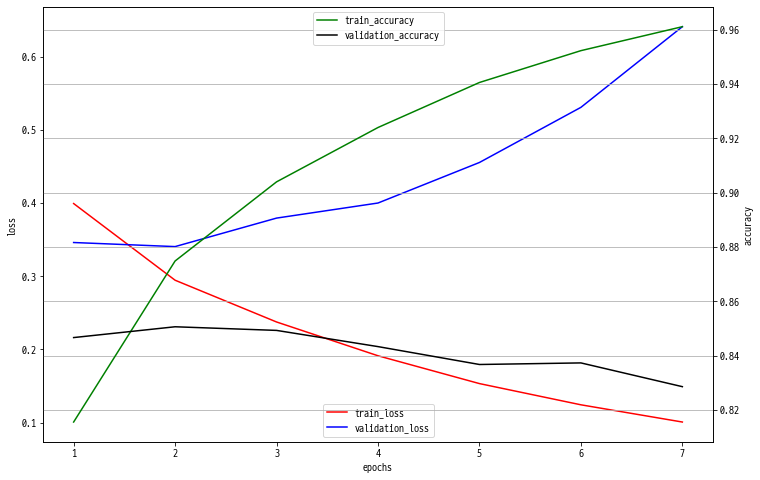

In [16]:
#(9) 훈련 과정 시각화하기. 
y_acc = model_fit.history['accuracy']
y_val_acc = model_fit.history['val_accuracy']

y_loss = model_fit.history['loss']
y_val_loss = model_fit.history['val_loss']
x_len = np.arange(1, len(y_acc)+1)

fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.set_xlabel('epochs')

ax0.plot(x_len, y_loss, c='red', label='train_loss')
ax0.plot(x_len, y_val_loss, c='blue', label='validation_loss')
ax0.set_ylabel('loss')
ax0.legend(loc='lower center')

ax1.plot(x_len, y_acc, c='green', label='train_accuracy')
ax1.plot(x_len, y_val_acc, c='k', label='validation_accuracy')
ax1.set_ylabel('accuracy')
ax1.legend(loc='upper center')

plt.grid()
plt.show()